*Semantic Segmentation is a computer vision task where the objective is to create a detailed pixel-wise segmentation map of an image, assigning each pixel to a specific class or object.The Segment Anything Model (SAM) is a foundational model pretrained on a vast dataset with 1 billion masks and 11 million images.*

*Prepare Data: For demonstration purposes, we use the Leaf Disease Segmentation from Kaggle. This dataset is a good example for automating disease detection in plants, especially for speeding up the plant pathology process.*

In [1]:
!pip install autogluon.multimodal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runti

In [3]:
download_dir = './ag_automm_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/semantic_segmentation/leaf_disease_segmentation.zip'
from autogluon.core.utils.loaders import load_zip
load_zip.unzip(zip_file, unzip_dir=download_dir)

*Next, load the CSV files, ensuring that relative paths are expanded to facilitate correct data loading during both training and testing.*

In [4]:
import pandas as pd
import os
dataset_path = os.path.join(download_dir, 'leaf_disease_segmentation')
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
val_data = pd.read_csv(f'{dataset_path}/val.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
image_col = 'image'
label_col = 'label'

In [5]:
def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

for per_col in [image_col, label_col]:
    train_data[per_col] = train_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
    val_data[per_col] = val_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
    test_data[per_col] = test_data[per_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))


print(train_data[image_col].iloc[0])
print(train_data[label_col].iloc[0])

/content/ag_automm_tutorial/leaf_disease_segmentation/train_images/00002.jpg
/content/ag_automm_tutorial/leaf_disease_segmentation/train_masks/00002.png


*Each Pandas DataFrame contains two columns: one for image paths and the other for corresponding groundtruth masks. Let's take a closer look at the training data DataFrame.*

In [6]:
train_data.head()

,image,label
0,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
1,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
2,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
3,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...
4,/content/ag_automm_tutorial/leaf_disease_segme...,/content/ag_automm_tutorial/leaf_disease_segme...


*We can also visualize one image and its groundtruth mask.*

In [6]:
!pip install torch==2.0.0+cu117 torchaudio==2.0.0 torchvision==0.15.0+cu117 --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.1
    Uninstalling torchvision-0.18.1:
      Successfully uninstalled torchvision-0.18.1
  Attempting uninstall: torchaudio
    Found e

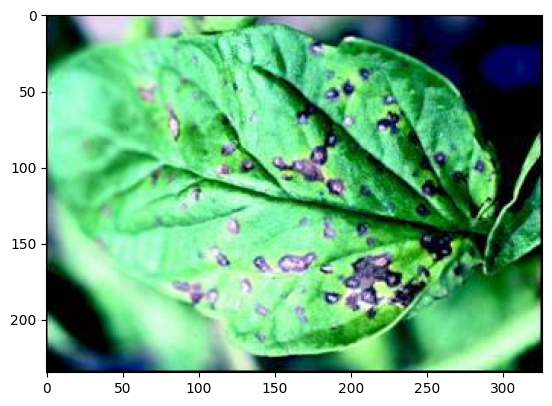

In [7]:
from autogluon.multimodal.utils import SemanticSegmentationVisualizer
visualizer = SemanticSegmentationVisualizer()
visualizer.plot_image(test_data.iloc[0]['image'])

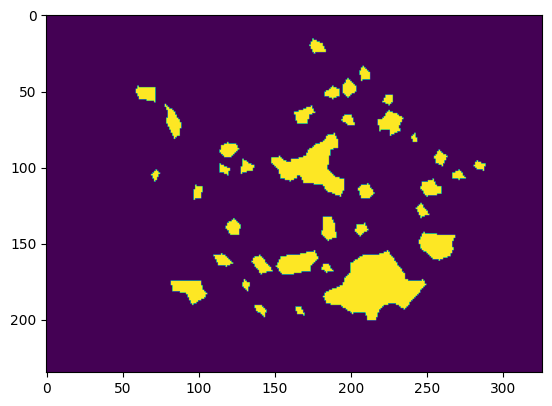

In [8]:
visualizer.plot_image(test_data.iloc[0]['label'])

*Zero Shot Evaluation: Now, let's see how well the pretrained SAM can segment the images. For this demonstration, we'll use the base SAM model.*

In [9]:
from autogluon.multimodal import MultiModalPredictor
predictor_zero_shot = MultiModalPredictor(
    problem_type="semantic_segmentation",
    label=label_col,
     hyperparameters={
            "model.sam.checkpoint_name": "facebook/sam-vit-base",
        },
    num_classes=1, # forground-background segmentation
)

*After initializing the predictor, you can perform inference directly.*

In [10]:
pred_zero_shot = predictor_zero_shot.predict({'image': [test_data.iloc[0]['image']]})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting: |          | 0/? [00:00<?, ?it/s]

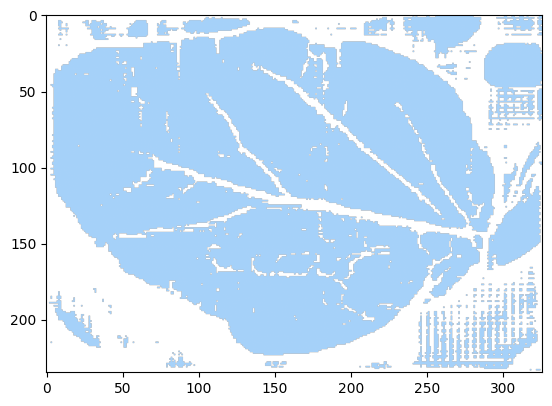

In [11]:
visualizer.plot_mask(pred_zero_shot)

*It's worth noting that SAM without prompts outputs a rough leaf mask instead of disease masks due to its lack of context about the domain task. While SAM can perform better with proper click prompts, it might not be an ideal end-to-end solution for some applications that require a standalone model for deployment.*

*You can also conduct a zero-shot evaluation on the test data.*

In [12]:
scores = predictor_zero_shot.evaluate(test_data, metrics=["iou"])
print(scores)

Predicting: |          | 0/? [00:00<?, ?it/s]

{'iou': 0.13999418914318085}


*As expected, the test score of the zero-shot SAM is relatively low. Next, let's explore how to fine-tune SAM for enhanced performance.*

*Finetune SAM: Initialize a new predictor and fit it with the training and validation data.*

In [13]:
from autogluon.multimodal import MultiModalPredictor
import uuid
save_path = f"./tmp/{uuid.uuid4().hex}-automm_semantic_seg"
predictor = MultiModalPredictor(
    problem_type="semantic_segmentation",
    label="label",
     hyperparameters={
            "model.sam.checkpoint_name": "facebook/sam-vit-base",
        },
    path=save_path,
)
predictor.fit(
    train_data=train_data,
    tuning_data=val_data,
    time_limit=180, # seconds
)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
Pytorch Version:    2.0.0+cu117
CUDA Version:       11.7
Memory Avail:       46.55 GB / 52.96 GB (87.9%)
Disk Space Avail:   64.30 GB / 112.64 GB (57.1%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/tmp/31ce935d80b0427ca1c937d6af8ae590-automm_semantic_seg
    ```

INFO: Seed set to 0
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
GPU Count

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 100: 'val_iou' reached 0.58314 (best 0.58314), saving model to '/content/tmp/31ce935d80b0427ca1c937d6af8ae590-automm_semantic_seg/epoch=0-step=100.ckpt' as top 3
INFO: Time limit reached. Elapsed time is 0:03:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 112: 'val_iou' reached 0.53776 (best 0.58314), saving model to '/content/tmp/31ce935d80b0427ca1c937d6af8ae590-automm_semantic_seg/epoch=1-step=112.ckpt' as top 3
AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/tmp/31ce935d80b0427ca1c937d6af8ae590-automm_semantic_seg")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




*After fine-tuning, evaluate SAM on the test data.*

In [14]:
scores = predictor.evaluate(test_data, metrics=["iou"])
print(scores)

Predicting: |          | 0/? [00:00<?, ?it/s]

{'iou': 0.5748315453529358}


*To visualize the impact, let's examine the predicted mask after fine-tuning.*

In [15]:
pred = predictor.predict({'image': [test_data.iloc[0]['image']]})

Predicting: |          | 0/? [00:00<?, ?it/s]

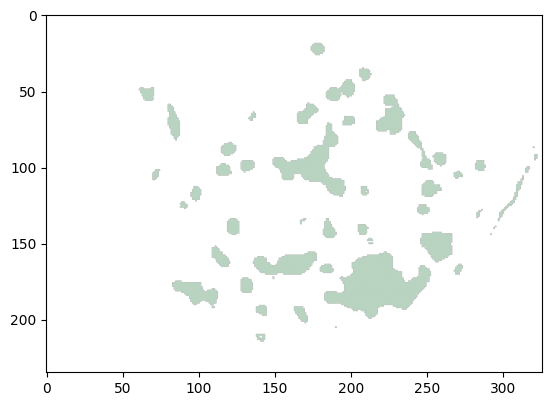

In [16]:
visualizer.plot_mask(pred)

*Save and Load: The trained predictor is automatically saved at the end of fit(), and you can easily reload it.*

In [17]:
loaded_predictor = MultiModalPredictor.load(save_path)
scores = loaded_predictor.evaluate(test_data, metrics=["iou"])
print(scores)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Load pretrained checkpoint: /content/tmp/31ce935d80b0427ca1c937d6af8ae590-automm_semantic_seg/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

{'iou': 0.5748315453529358}
